In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

In [2]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [3]:
def Regression(df, independent_vars, dependent_var): # Function to run regression
    model_df = df.copy()
    model_df = model_df.set_index(['iso3', 'year'])
    # Drop rows with NaN values only in the independent and dependent variable columns
    model_df = model_df.dropna(subset=independent_vars + [dependent_var])
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)
    return results

In [4]:
def plot(df,x,y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x=x, y=y,hue='region')
    sns.regplot(data=df, x=x, y=y, scatter=False, color='red', line_kws={"label": "Trend Line"})    

In [5]:
path = 'Datasets/'
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
birth = pd.read_csv(path + 'Birth rate, crude (per 1,000 people)/WB_WDI_SP_DYN_CBRT_IN.csv',encoding='latin1') # Births
fertility = pd.read_csv(path + 'Fertility rate, total (births per woman)/WB_WDI_SP_DYN_TFRT_IN.csv',encoding='latin1') # Fertility

## HDR

In [6]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [7]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [8]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [9]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators)]
gii = HDR[HDR['indicator'].isin(GII_indicators)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators)]

In [10]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [11]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

## Birth

In [12]:
BIR = birth.copy()
BIR = BIR[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
BIR.loc[:, 'OBS_VALUE'] = BIR.loc[:, 'OBS_VALUE']/10
BIR.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'BIRTH'},inplace=True)
BIR['year'] = pd.to_datetime(BIR['year'], format='%Y',errors='coerce').dt.year

In [13]:
FER = fertility.copy()
FER = FER[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
FER.loc[:, 'OBS_VALUE'] = FER.loc[:, 'OBS_VALUE']/10
FER.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'FERT'},inplace=True)
FER['year'] = pd.to_datetime(FER['year'], format='%Y',errors='coerce').dt.year

# Merge

In [14]:
GII_BIR = pd.merge(GII, BIR, on=['iso3','year'], how='left')
GII_BIR.dropna(subset=[HDR_idx['gii'],'BIRTH'], inplace=True)
GII_FER = pd.merge(GII, FER, on=['iso3','year'], how='left')
GII_FER.dropna(subset=[HDR_idx['gii'],'FERT'], inplace=True)

# Birth

array([[1.        , 0.82397555],
       [0.82397555, 1.        ]])

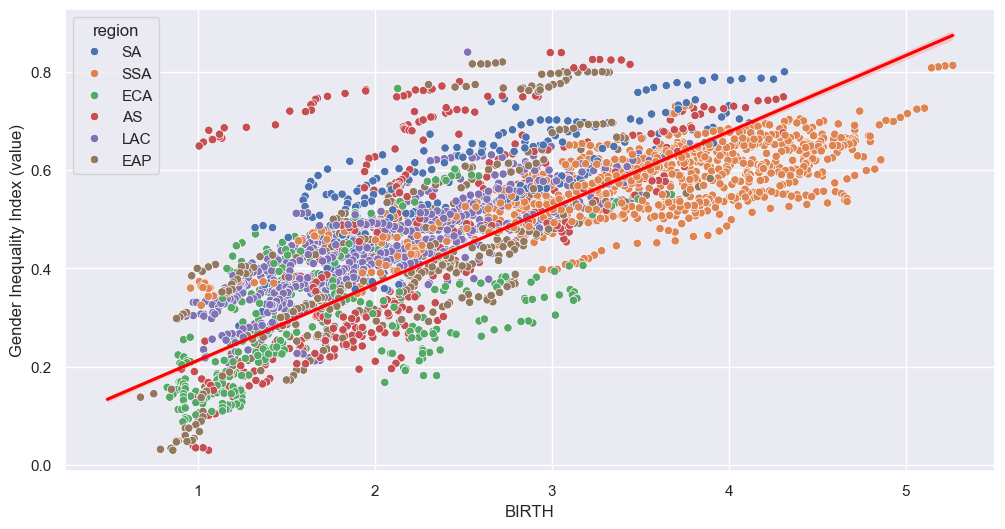

In [28]:
plot(GII_BIR, 'BIRTH', HDR_idx['gii'])
np.corrcoef(GII_BIR[HDR_idx['gii']], GII_BIR['BIRTH'])

In [16]:
Regression(GII_BIR, ['BIRTH'], HDR_idx['gii'])

Dep. Variable:,Gender Inequality Index (value),R-squared:,0.0096
Estimator:,PanelOLS,R-squared (Between):,0.1982
No. Observations:,4428,R-squared (Within):,0.1063
Date:,"Wed, May 14 2025",R-squared (Overall):,0.1884
Time:,12:50:11,Log-likelihood,7410.8
Cov. Estimator:,Clustered,,
,,F-statistic:,40.849
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,3.5210


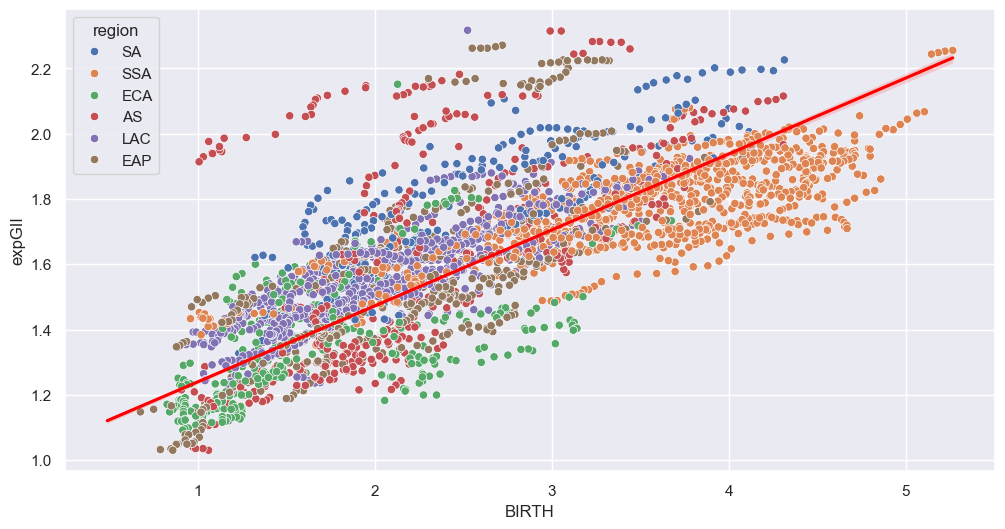

In [17]:
GII_BIR['expGII'] = np.exp(GII_BIR[HDR_idx['gii']])
plot(GII_BIR, 'BIRTH', 'expGII')

In [18]:
Regression(GII_BIR, ['BIRTH'], 'expGII')

Dep. Variable:,expGII,R-squared:,0.0346
Estimator:,PanelOLS,R-squared (Between):,0.3922
No. Observations:,4428,R-squared (Within):,0.2007
Date:,"Wed, May 14 2025",R-squared (Overall):,0.3658
Time:,12:50:14,Log-likelihood,5232.9
Cov. Estimator:,Clustered,,
,,F-statistic:,151.37
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,12.958


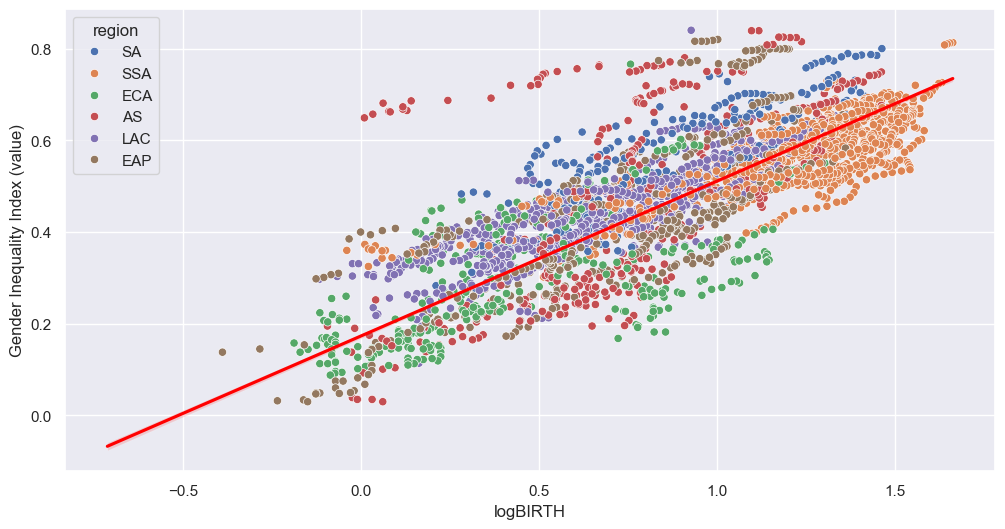

In [19]:
GII_BIR['logBIRTH'] = np.log(GII_BIR['BIRTH'])
plot(GII_BIR, 'logBIRTH', HDR_idx['gii'])

In [20]:
Regression(GII_BIR, ['BIRTH'], 'expGII')

Dep. Variable:,expGII,R-squared:,0.0346
Estimator:,PanelOLS,R-squared (Between):,0.3922
No. Observations:,4428,R-squared (Within):,0.2007
Date:,"Wed, May 14 2025",R-squared (Overall):,0.3658
Time:,12:50:16,Log-likelihood,5232.9
Cov. Estimator:,Clustered,,
,,F-statistic:,151.37
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,12.958


# Fertility

array([[1.       , 0.7768448],
       [0.7768448, 1.       ]])

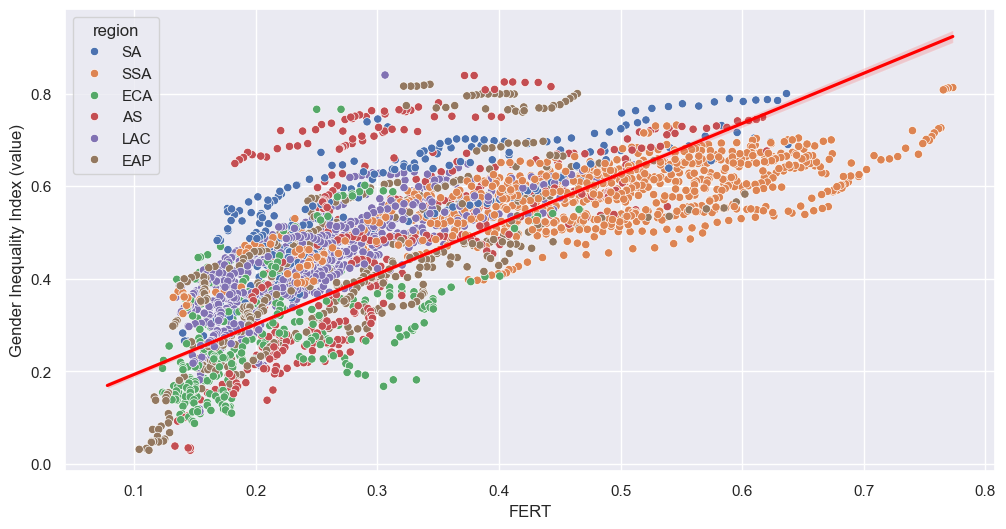

In [21]:
plot(GII_FER, 'FERT', HDR_idx['gii'])
np.corrcoef(GII_FER['FERT'], GII_FER[HDR_idx['gii']])

In [22]:
Regression(GII_FER, ['FERT'], HDR_idx['gii'])

Dep. Variable:,Gender Inequality Index (value),R-squared:,0.0186
Estimator:,PanelOLS,R-squared (Between):,0.2120
No. Observations:,4428,R-squared (Within):,0.1167
Date:,"Wed, May 14 2025",R-squared (Overall):,0.1969
Time:,12:50:18,Log-likelihood,7431.0
Cov. Estimator:,Clustered,,
,,F-statistic:,79.985
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,5.4369


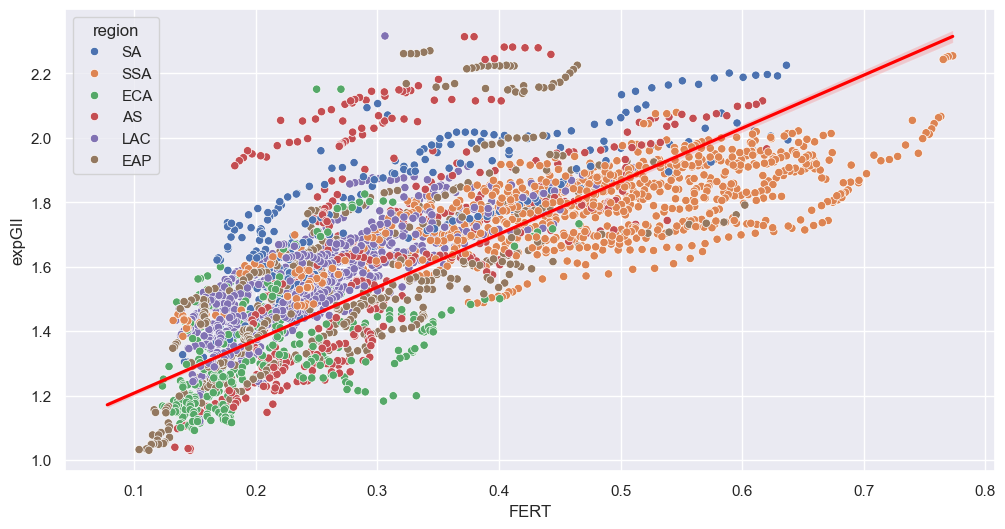

In [23]:
GII_FER['expGII'] = np.exp(GII_FER[HDR_idx['gii']])
plot(GII_FER, 'FERT', 'expGII')

In [24]:
Regression(GII_FER, ['FERT'], 'expGII')

Dep. Variable:,expGII,R-squared:,0.0591
Estimator:,PanelOLS,R-squared (Between):,0.3930
No. Observations:,4428,R-squared (Within):,0.2133
Date:,"Wed, May 14 2025",R-squared (Overall):,0.3614
Time:,12:50:19,Log-likelihood,5289.8
Cov. Estimator:,Clustered,,
,,F-statistic:,265.27
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,19.167


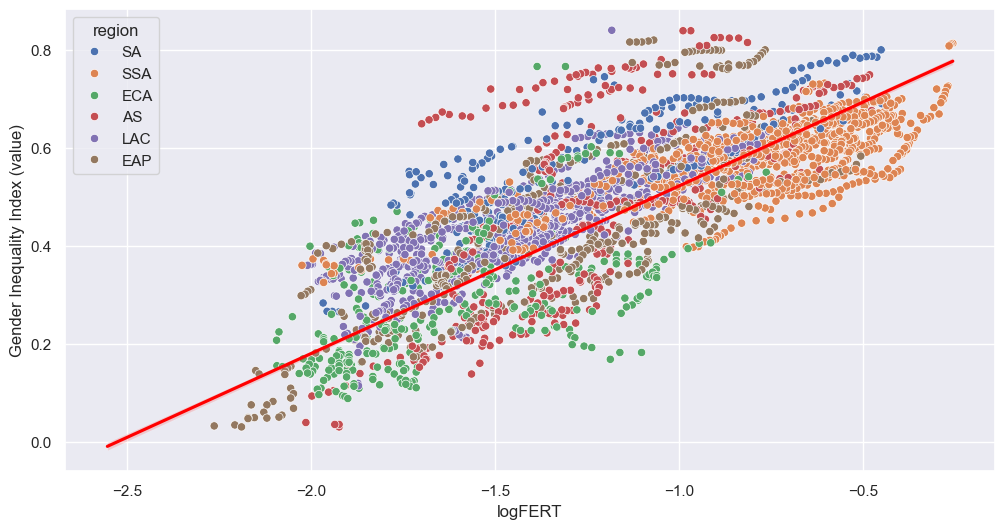

In [25]:
GII_FER['logFERT'] = np.log(GII_FER['FERT'])
plot(GII_FER, 'logFERT', HDR_idx['gii'])


In [26]:
Regression(GII_FER, ['logFERT'], HDR_idx['gii'])

Dep. Variable:,Gender Inequality Index (value),R-squared:,0.0373
Estimator:,PanelOLS,R-squared (Between):,0.3065
No. Observations:,4428,R-squared (Within):,0.1634
Date:,"Wed, May 14 2025",R-squared (Overall):,0.2856
Time:,12:50:21,Log-likelihood,7473.7
Cov. Estimator:,Clustered,,
,,F-statistic:,163.78
Entities:,172,P-value,0.0000
Avg Obs:,25.744,Distribution:,"F(1,4223)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,5.7720
